In this lab we will train a conditional generative adversarial network (cGAN) to synthesize **T2-w MRI** from **T1-w MRI**.

The outline of this lab is:
1. Create a cGAN with a given architecture for the generator and for the discriminator
2. Train this cGAN on the [IXI dataset](https://brain-development.org/ixi-dataset/) to transform **T1-w MRI** into **T2-w MRI**.
3. Evaluate the quality of the generated images using standard metrics.

But first we will fetch the dataset and have a look at it to see what the tasks looks like.

# 0. Fetching the dataset

The dataset can be found on this [GitHub repository](https://github.com/Easternwen/IXI-dataset). In the `size64` folder, there are 1154 files: 2 images for 577 subjects. The size of each image is (64, 64).

Let's clone the repository and have a look at the data.

In [0]:
# Get the dataset from the GitHub repository
! git clone https://github.com/Easternwen/IXI-dataset.git

fatal: destination path 'IXI-dataset' already exists and is not an empty directory.


The dataset used in this lab is composed of preprocessed images from the [IXI dataset](https://brain-development.org/ixi-dataset/). Two different structural MRI modalities are comprised in this dataset:
- T1 weighted images
- T2 weighted images

These modalities do not highlight the same tissues: for example the CSF voxels are cancelled in T1 weighted imaging whereas they are highlighted by the T2 weighted imaging.

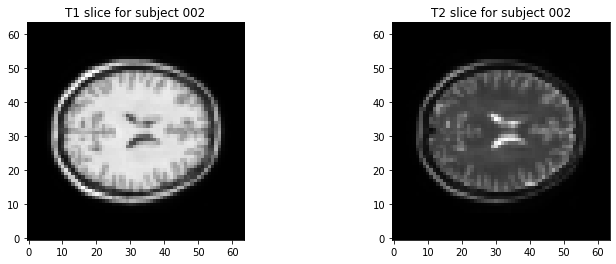

In [0]:
import matplotlib.pyplot as plt
import os
import torch

input_path = "./IXI-dataset/size64/"

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(torch.load(os.path.join(input_path, 'sub-IXI002 - T1.pt')), cmap='gray', origin='lower')
plt.title("T1 slice for subject 002")

plt.subplot(1, 2, 2)
plt.imshow(torch.load(os.path.join(input_path, 'sub-IXI002 - T2.pt')), cmap='gray', origin='lower')
plt.title("T2 slice for subject 002");

In [0]:
from __future__ import print_function


import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

import time
from torchsummary import summary

import datetime
import sys
from torchvision.utils import save_image

Let's create a custom `MvaDataset` class to easily have access to the data.
Here we don't use tsv files to split subjects between the training and the test set. We only set the dataset to the `train` or `test` mode to access training or test data.

In [0]:
import os


# Create the dataset

class MvaDataset(torch.utils.data.Dataset):
    """Dataset utility class.

    Parameters
    ----------
    root : str
        Path of the folder with all the images.

    mode : {'train' or 'test'} (default = 'train')
        Part of the dataset that is loaded. Use 'train' to get the training set
        and 'test' to get the test set.

    """
    def __init__(self, root, mode="train"): 
        
        files = sorted(os.listdir(root)) 
        patient_id = list(set([i.split()[0] for i in files]))
        
        imgs = []
        
        if mode =="train":   
            for i in patient_id[:int(0.8*len(patient_id))]:
                if os.path.isfile(os.path.join(root, i + " - T1.pt")) and os.path.isfile(os.path.join(root, i + " - T2.pt")):
                    imgs.append((os.path.join(root, i + " - T1.pt"), os.path.join(root, i + " - T2.pt")))
        
        elif mode =="test":
            for i in patient_id[int(0.8*len(patient_id)):]:
                if os.path.isfile(os.path.join(root, i + " - T1.pt")) and os.path.isfile(os.path.join(root, i + " - T2.pt")):
                    imgs.append((os.path.join(root, i + " - T1.pt"), os.path.join(root, i + " - T2.pt")))            
        
        self.imgs = imgs
        
    def __getitem__(self, index):
        t1_path, t2_path = self.imgs[index]
        
        t1 = torch.load(t1_path)[None, :, :]
        t2 = torch.load(t2_path)[None, :, :]
            
        return {"T1": t1, "T2": t2}

    def __len__(self):
        return len(self.imgs)
  

Using this class and the `DataLoader` class from `torch.utils.data`, you can easily have access to your dataset. Here is a quick
example on how to use it:

```python
from torch.utils.data import DataLoader

root = "./IXI-dataset/size64/"

# Create a DataLoader instance for the training set
# You will get a batch of samples from the training set
dataloader = DataLoader(
    MvaDataset(root, mode="train"),
    batch_size=batch,
    shuffle=False,
)

for batch in dataloader:
    # batch is a dictionary with two keys:
    # - batch["T1"] is a tensor with shape (batch_size, 64, 64) with the T1 images for the samples in this batch
    # - batch["T2"] is a tensor with shape (batch_size, 64, 64) with the T2 images for the samples in this batch
```

# 1. Creating your conditional GAN

## 1.1 Generator = U-Net

For the generator we will use a U-Net where:
* the descending blocks are convolutional layers followed by instance normalization with a LeakyReLU activation function;
* the ascending blocks are transposed convolutional layers followed by instance normalization with a ReLU activation function.

The parameters for each layer are given in the picture below.

<a href="https://ibb.co/QXBDNy3"><img src="https://i.ibb.co/g614TkL/Capture-d-cran-2020-03-02-16-04-06.png" width="800" alt="Capture-d-cran-2020-03-02-16-04-06" border="0"></a>

In [0]:
#@title
%%html
<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  <b>Exercise</b>: Create a <code>GeneratorUNet</code> class to define the generator
  with the architecture given above.
</div>

In [0]:
# Below are modules implemented to define the generator more easily. Feel free to use them or not !

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetDown, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.LeakyReLU(0.2)
          )

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1) # add the skip connection
        x = self.model(x)
        return x

class FinalLayer(nn.Module):
    def __init__(self, in_size, out_size):
        super(FinalLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1) # add the skip connection
        x = self.model(x)
        return x

In [0]:
##############################
#      Generator U-NET
##############################

class GeneratorUNet(nn.Module):
    def __init__(self):
        super(GeneratorUNet, self).__init__()
        # TODO
        self.d5 = UNetDown(1, 64)
        self.d4 = UNetDown(64, 128)
        self.d3 = UNetDown(128, 256)
        self.d2 = UNetDown(256, 512)
        self.d1 = UNetDown(512, 512)

        self.u1 = UNetUp(512, 512)
        self.u2 = UNetUp(1024, 256)
        self.u3 = UNetUp(512, 128)
        self.u4 = UNetUp(256, 64)

        self.final = FinalLayer(128, 1)

    def forward(self, x):
        # TODO
        d5 = self.d5(x)
        d4 = self.d4(d5)
        d3 = self.d3(d4)
        d2 = self.d2(d3)
        d1 = self.d1(d2)

        u1 = self.u1(d1)
        u2 = self.u2(u1, d2)
        u3 = self.u3(u2, d3)
        u4 = self.u4(u3, d4)

        final = self.final(u4, d5)

        return final

In [0]:
# Summary of the generator 
G = GeneratorUNet().cuda()
summary(G, (1, 64, 64) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
    InstanceNorm2d-2           [-1, 64, 32, 32]               0
         LeakyReLU-3           [-1, 64, 32, 32]               0
          UNetDown-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
    InstanceNorm2d-6          [-1, 128, 16, 16]               0
         LeakyReLU-7          [-1, 128, 16, 16]               0
          UNetDown-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
   InstanceNorm2d-10            [-1, 256, 8, 8]               0
        LeakyReLU-11            [-1, 256, 8, 8]               0
         UNetDown-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
   InstanceNorm2d-14            [-1, 51

## 1.2 Discriminator = 2D-CNN

For the discriminator we will use a two-dimensional convolutional neural network with 5 layers:
* the first 4 layers are 2D-convolutional layers with a LeakyReLU activation function.
* the last layer is a 2D-convolutional layer.

The parameters for each layer are given in the figure below. Don't forget that the input of the discriminator will be the generated image and the true image since we are using a conditional GAN. Therefore, the number of input channels for the first layer will be two (one for each image).

<a href="https://ibb.co/9b2jF0V"><img src="https://i.ibb.co/hBHvPNZ/Capture-d-cran-2020-03-02-16-04-14.png" width="800" alt="Capture-d-cran-2020-03-02-16-04-14" border="0"></a>

In [0]:
#@title
%%html
<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  <b>Exercise</b>: Create a <code>Discriminator</code> class to define the discriminator
  with the architecture given above.
</div>

In [0]:
# Define the blocks used for the discriminator 

def discriminator_block(in_filters, out_filters, normalization=False):
    """Returns downsampling layers of each discriminator block"""
    layers = [nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1)]
    if normalization:
        layers.append(nn.InstanceNorm2d(out_filters))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers

#############################
#        Discriminator
##############################

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO
        layers = []
        layers.extend(discriminator_block(2, 64))
        layers.extend(discriminator_block(64, 128))
        layers.extend(discriminator_block(128, 256))
        layers.extend(discriminator_block(256, 512))
        layers.append(nn.Conv2d(512, 1, 4, padding=0))
        self.model = nn.Sequential(*layers)

    def forward(self, T1_img, T2_img):
        # TODO
        img_input = torch.cat((T1_img, T2_img), 1)
        return self.model(img_input)

In [0]:
# Summary of the discriminator 
D = Discriminator().cuda()
summary(D, [(1, 64, 64), (1, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,216
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
         LeakyReLU-4          [-1, 128, 16, 16]               0
            Conv2d-5            [-1, 256, 8, 8]         295,168
         LeakyReLU-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 512, 4, 4]       1,180,160
         LeakyReLU-8            [-1, 512, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           8,193
Total params: 1,558,593
Trainable params: 1,558,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 64.00
Forward/backward pass size (MB): 1.88
Params size (MB): 5.95
Estimated Total Size (MB): 71.82
-------------------------------------

# 2. Training our conditional GAN

Now that we have created our generator and our discriminator, we have to train them on the dataset.

**Notations**

* $X_{T1}$: true T1 image;
* $X_{T2}$: true T2 image;
* $\tilde{X}_{T2}$: generated T2 image from $X_{T1}$;
* $\hat{y}_{X}$: probability returned by the discriminator that the ${X}_{T2}$ is real;
* $\hat{y}_{\tilde{X}}$: probability returned by the discriminator that the $\tilde{X}_{T2}$ is real.

**Training the generator**

The loss for the generator is the sum of:
* the binary cross-entropy loss between the predicted probabilities of the generated images and positive labels,
* the pixel-wise mean absolute error between the generated image and the true image.

For one sample, it is then:
$$
\ell_G = - \log(\hat{y}_{\tilde{X}}) + \lambda * \text{MAE}(X_{T2}, \tilde{X}_{T2})
$$

**Training the discriminator**

The loss for the generator is the mean of:
* the binary cross-entropy loss between the predicted probabilities of the generated images and negative labels,
* the binary cross-entropy loss between the predicted probabilities of the true images and positive labels.

For one sample, it is then:
$$
\ell_D = - 0.5 * \log(\hat{y}_{X}) - 0.5 * \log(1 - \hat{y}_{\tilde{X}})
$$

**Training phase**

The generator and the discriminator are trained simultaneously, which makes the training phase look like this:

```
# For each epoch

    # For each batch

        # Generate fake images for all the images in this batch

        # Compute the loss for the generator and perform one optimization step

        # Compute the loss for the discriminator and perform one optimization step
```

In [0]:
#@title
%%html
<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  <b>Exercise</b>: We provide below a template to train our conditional GAN
  on the dataset. Fill in the missing parts and look at the generated images.
</div>

In [0]:
def train(train_loader, test_loader, num_epoch=500,
          lr=0.0001, beta1=0.9, beta2=0.999):
    """
    Method used to train a generator in an adversarial framework.
    
    Args:
        train_loader: (DataLoader) a DataLoader wrapping a the training dataset
        test_loader: (DataLoader) a DataLoader wrapping a the training dataset
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers
        beta1: (float) beta1 coefficient of the discriminator and generator Adam optimizers
        beta2: (float) beta1 coefficient of the discriminator and generator Adam optimizers

    Returns:
        generator: (nn.Module) the trained generator
    """

    cuda = True if torch.cuda.is_available() else False
    print("cuda %s"%(cuda))  # check if GPU is used 

    # Tensor type (put everything on GPU if possible)
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor 

    # Output folder 
    if not os.path.exists("./images"):
        os.makedirs("./images")
     
    # Loss functions
    criterion_GAN = torch.nn.BCEWithLogitsLoss() # A loss adapted to binary classification like torch.nn.BCEWithLogitsLoss
    criterion_pixelwise = torch.nn.L1Loss() # A loss for a voxel-wise comparison of images like torch.nn.L1Loss

    lambda_GAN  = 1 # Weights criterion_GAN in the generator loss
    lambda_pixel = 0 # Weights criterion_pixelwise in the generator loss

    # Initialize generator and discriminator
    generator = GeneratorUNet()
    discriminator = Discriminator()

    if cuda:
        generator = generator.cuda()
        discriminator = discriminator.cuda()
        criterion_GAN.cuda()
        criterion_pixelwise.cuda()

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))  
     
    def sample_images(epoch):
        """Saves a generated sample from the validation set"""
        imgs = next(iter(test_loader))
        real_A = Variable(imgs["T1"].type(Tensor))
        real_B = Variable(imgs["T2"].type(Tensor))
        fake_B = generator(real_A)
        img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
        save_image(img_sample, "./images/epoch-%s.png" % epoch, nrow=5, normalize=True)
        
    # ----------
    #  Training
    # ----------

    prev_time = time.time()
    
    for epoch in range(num_epoch):
        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_A = Variable(batch["T1"].type(Tensor))
            real_B = Variable(batch["T2"].type(Tensor))
            
            # Create labels
            valid = Variable(Tensor(np.ones((real_B.size(0), 1, 1, 1))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((real_B.size(0), 1, 1, 1))), requires_grad=False)
            
            # ------------------
            #  Train Generators
            # ------------------
            optimizer_G.zero_grad()

            # GAN loss
            fake_B = generator(real_A)
            pred_fake = discriminator(fake_B, real_A)
            loss_GAN = criterion_GAN(pred_fake, valid)
            loss_pixel = criterion_pixelwise(fake_B, real_B)

            # Total loss
            loss_G = lambda_GAN * loss_GAN + lambda_pixel * loss_pixel

            loss_G.backward()
            optimizer_G.step()
                            
                            
            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Real loss
            pred_real = discriminator(real_B, real_A)
            loss_real = criterion_GAN(pred_real, valid) # loss on real inputs

            # Fake loss
            pred_fake = discriminator(fake_B.detach(), real_A)
            loss_fake = criterion_GAN(pred_fake, fake) # loss on generated inputs

            # Total loss
            loss_D = 0.5 * (loss_real + loss_fake)

            loss_D.backward()
            optimizer_D.step()
                            
            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(train_loader) + i
            batches_left = num_epoch * len(train_loader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()
                            
            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
                % (
                    epoch,
                    num_epoch,
                    i,
                    len(train_loader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_pixel.item(),
                    loss_GAN.item(),
                    time_left,
                )
            )            
                            
        # Save images at the end of each epoch
        sample_images(epoch)

    return generator

In [0]:
root = "./IXI-dataset/size64/"

# Parameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create dataloaders
batch_size = 40
train_loader = DataLoader(MvaDataset(root, mode="train"),
                          batch_size=batch_size,
													shuffle=True,
													)

test_loader = DataLoader(MvaDataset(root, mode="test"),
                         batch_size=5,
												 shuffle=False,
												 )

num_epoch = 20

generator = train(train_loader, test_loader, num_epoch=num_epoch, lr=lr, beta1=beta1, beta2=beta2)

cuda True
[Epoch 19/20] [Batch 11/12] [D loss: 0.694072] [G loss: 0.692156, pixel: 0.086291, adv: 0.692156] ETA: 0:00:00.127055

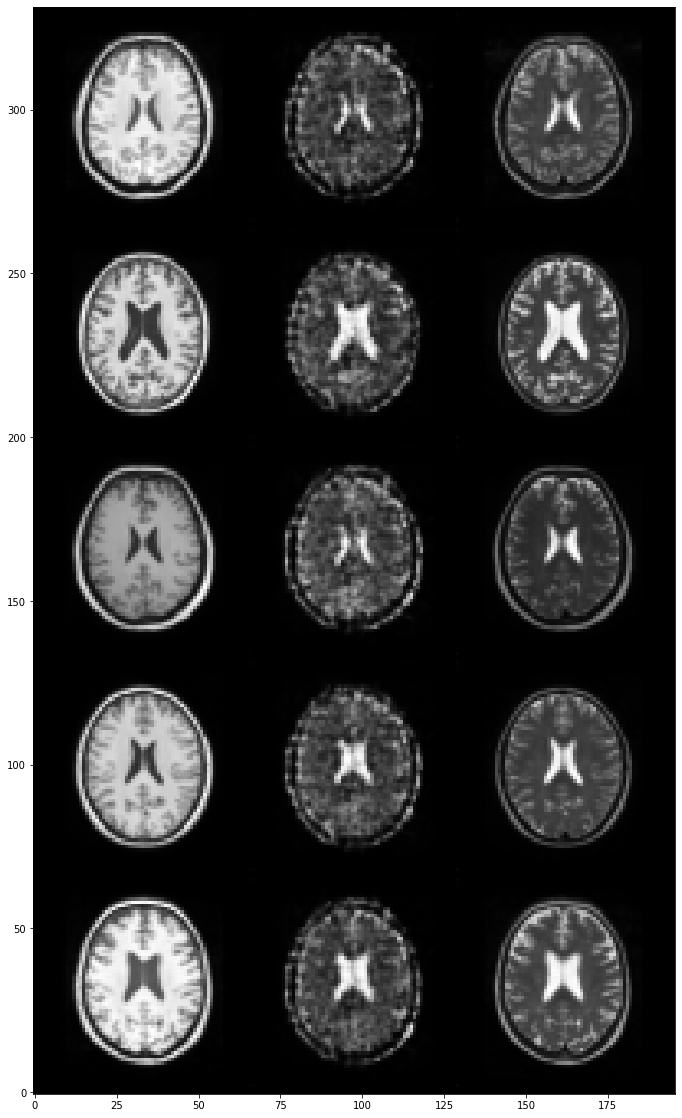

In [0]:
import matplotlib.pyplot as plt 
import matplotlib.image as img 

plt.figure(figsize=(20,20))
# reading png image file 
im = img.imread('./images/epoch-%s.png' % (num_epoch - 1))
plt.imshow(np.swapaxes(im,0,1))
plt.gca().invert_yaxis()
plt.show()

# 3. Evaluating the quality of the generated images

After doing visual quality control, it is a good idea to quantify the quality of the generated images using specific metrics. The most popular metrics are Mean Squared Error (MSE), Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity index (SSIM):
* MSE = $ \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m (T_{ij} - G_{ij}) $

* PSNR = $10 \log_{10} \left( \frac{MAX_I^2}{MSE} \right) $ where $MAX_I^2$ is the maximum possible value of the image (equal to 1 in our case since the images are scaled in range $[-1, 1]$). The higher, the better. 

* SSIM = $ \frac{(2 \mu_T \mu_G + C_1)(2 \sigma_{TG} + C_2)}{(\mu_T^2 + \mu_G^2 + C_1)(\sigma_T^2 + \sigma_G^2 + C2)} $ where $\mu$ and $\sigma$ are the mean value and standard deviation of an image respectively and $C_1$ and $C_2$ are two positive constants (one can take $C_1=0.01$ and $C_2=0.03$).

To better understand the differences between metrics: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

In [0]:
#@title
%%html
<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  <b>Exercise</b>: Define a function for each metric mentioned above and
  evaluate the quality of the generated images on the training and test
  sets. Compute the metrics for each image individually and find the best
  and worst generated images according to these metrics.
</div>

In [0]:
def MSE(image_true, image_generated):
    return ((image_true - image_generated) ** 2).mean()


def PSNR(image_true, image_generated):
    mse = MSE(image_true, image_generated).cpu()
    return -10 * np.log10(mse)


def SSIM(image_true, image_generated, C1=0.01, C2=0.03):
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = ((image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = (2 * mean_true * mean_generated + C1) * (2 * covariance + C2)
    denominator = (mean_true ** 2 + mean_generated ** 2 + C1) * (std_true ** 2 + std_generated ** 2 + C2)
    return numerator / denominator

In [0]:
import pandas as pd

def evaluate_metrics(dataloader):

    res = []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor 

    for i, batch in enumerate(dataloader):

        # Inputs T1-w and T2-w
        real_A = Variable(batch["T1"].type(Tensor), requires_grad=False)
        real_B = Variable(batch["T2"].type(Tensor), requires_grad=False)
        fake_B = Variable(generator(real_A), requires_grad=False)

        mse = MSE(real_B, fake_B).item()
        psnr = PSNR(real_B, fake_B).item()
        ssim = SSIM(real_B, fake_B).item()

        res.append([mse, psnr, ssim])

    df = pd.DataFrame(res, columns=['MSE', 'PSNR', 'SSIM'])
    return df

In [0]:
train_loader = DataLoader(
    MvaDataset(root=root, mode="train"),
    batch_size=1,
    shuffle=False,
)

test_dataloader = DataLoader(
    MvaDataset(root=root, mode="test"),
    batch_size=1,
    shuffle=False,
)

df_train = evaluate_metrics(train_loader)
df_test = evaluate_metrics(test_loader)

In [0]:
df_train

,MSE,PSNR,SSIM
0,0.027602,15.590602,0.896102
1,0.025271,15.973754,0.911109
2,0.025364,15.957851,0.932440
3,0.022533,16.471813,0.920176
4,0.035025,14.556244,0.888277
...,...,...,...
456,0.030919,15.097797,0.897559
457,0.025564,15.923655,0.900665
458,0.036177,14.415691,0.896038
459,0.030292,15.186700,0.908964


In [0]:
df_test

,MSE,PSNR,SSIM
0,0.029004,15.375368,0.905485
1,0.031089,15.073905,0.902661
2,0.029720,15.269526,0.894119
3,0.029147,15.354100,0.897958
4,0.028657,15.427718,0.904822
5,0.032086,14.936862,0.888220
6,0.029097,15.361565,0.908176
7,0.024882,16.041128,0.903723
8,0.026833,15.713253,0.903234
9,0.030373,15.175135,0.899046
